In [16]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps

from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

colors={'direct':'#3d7f1e',
        'indirect':'#b1116d',
        'total':'darkorange'
        }

In [17]:
data_dir='/home/anthe/documents/misu/thesis/aerosol-prp/datasets/'
linla_dir='/home/anthe/documents/misu/thesis/abrupt-aerosol/abrupt-aerosol-linla/datasets/'
ref_dir='/home/anthe/documents/misu/thesis/abrupt-aerosol/abrupt-aerosol-anthe/datasets/'
piControl_dir='/home/anthe/documents/misu/thesis/development/datasets/'

historical_dir='/home/anthe/documents/misu/thesis/aerosol-prp/datasets/historical/'
MACSP_dir = '/home/anthe/documents/misu/thesis/'
fig_dir='/home/anthe/documents/misu/thesis/aerosol-prp/figures/'

macsp = xr.open_dataset(f'{MACSP_dir}/MAC-SP.nc')

In [20]:
macsp.aod_fmbg.values

array([0.1, 0.1, 0.1, 0.1, 0.6, 0.6, 0.6, 0.6, 0.1], dtype=float32)

In [3]:
emissions = pd.DataFrame({
    'Europe': [8.95, 18.26, 56.80, 16.41, 11.35],
    'North America': [7.65, 24.09, 29.32, 17.45, 7.39],
    'East Asia': [0.17, 1.69, 14.72, 37.36, 34.89],
    'South Asia': [0.18, 1.57, 9.18, 17.17, 22.89],
    'North Africa': [0.08, 0.20, 1.02, 1.70, 1.94],
    'South America': [0.12, 1.24, 4.81, 4.88, 5.26],
    'Maritime Continent': [0.03, 0.22, 2.13, 4.15, 4.43],
    'South Central Africa': [0.04, 1.42, 3.83, 3.35, 4.29],
    'Australia': [0.23, 0.63, 1.61, 1.57, 1.39],
    #'Global': [17.54, 49.32, 123.42, 104.04, 70.94]
},
index=[1900, 1950, 1980, 2005, 2013])

emission = pd.DataFrame({
    'Global': [17.54, 49.32, 123.42, 104.04, 93.83]
},
index=[1900, 1950, 1980, 2005, 2013])

sum = macsp.year_weight.sel(plume_number=1).isel(years=slice(0,164)).values * 0
for year in range(0, 164, 1):
    for plume_number in range(1, 10 ,1):
        sum[year] = sum[year] + macsp.year_weight.sel(plume_number=plume_number).isel(years=year)*emissions.iloc[:, plume_number-1].loc[2005]

In [4]:
def regression(temperature, imbalance):

    reg = sps.linregress(temperature, imbalance)
    
    return reg.slope, reg.intercept#, reg.stderr, reg.intercept_stderr 

def WeightedMean(var):
    weights = np.cos(np.deg2rad(var.lat))
    if len(var.shape) >= 2:
        return var.weighted(weights).mean(dim=('lat', 'lon'))
    else:
        return var.weighted(weights).mean("lat")

/home/anthe/anaconda3/envs/misu/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
/home/anthe/anaconda3/envs/misu/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


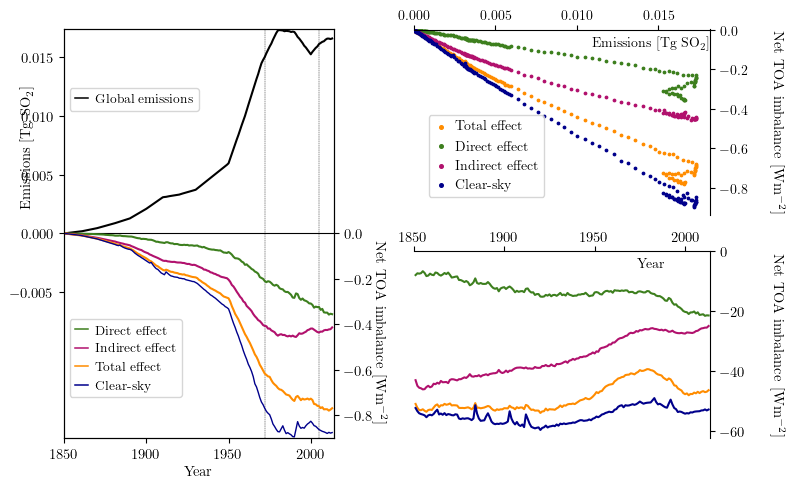

In [15]:
def plot():

    #fig = plt.gcf()
    #fig.set_size_inches(10, 8)
    fig = plt.figure()
    gs = GridSpec(2,2, width_ratios=[1,1.1])
    ax1 = fig.add_subplot(gs[:, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    #ax1 = plt.subplot(121)
    #ax3 = plt.subplot(223)
    #ax4 = plt.subplot(224)
    #fig, axs = plt.subplots(2,2,figsize=(6,6), gridspec_kw={'width_ratios': [2, 2]})
    #fig.delaxes(axs[1, 0])

    #ax1 = axs[0,0]
    ax2 = ax1.twinx()

    prp = xr.open_dataset('../../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()

    time = np.arange(1850, 1850 + prp.time.size, 1)

    plt.axhline(0, color='black', linewidth=0.8)

    ax2.plot(time, (prp.dR_spd_srad0.values + prp.dR_spd_trad0.values), color=colors['direct'], linestyle='-', label='direct effect')
    ax2.plot(time, (prp.dR_spi_srad0.values + prp.dR_spi_trad0.values), color=colors['indirect'], linestyle='-', label='indirect effect')
    ax2.plot(time, (prp.dR_sp_srad0.values + prp.dR_sp_trad0), 'darkorange', linestyle='-', label='total effect')
    ax2.plot(time, (prp.dR_spd_sraf0.values + prp.dR_spd_traf0), 'darkblue', linestyle='-', linewidth=1,label='aerosol effect clear-sky')

    ax4.plot(time, (prp.dR_spd_srad0.values + prp.dR_spd_trad0.values)/prp.aod_sp, color=colors['direct'], linestyle='-', linewidth=1.5, label='normalized by emissions')
    ax4.plot(time, (prp.dR_spi_srad0.values + prp.dR_spi_trad0.values)/prp.aod_sp, color=colors['indirect'], linestyle='-', linewidth=1.5,label='indirect effect')
    ax4.plot(time, (prp.dR_sp_srad0.values + prp.dR_sp_trad0)/prp.aod_sp, 'darkorange', linestyle='-', linewidth=1.5,label='total effect')
    ax4.plot(time, (prp.dR_sp_sraf0.values + prp.dR_sp_traf0)/prp.aod_sp, 'darkblue', linestyle='-', linewidth=1.5,label='clear-sky')
    
    ax1.plot(time, prp.aod_sp, 'black', label='Global emissions')

    ax2.set_ylim([-.9, .9])    
    ax1.set_ylim([-max(prp.aod_sp)-0.0001, max(prp.aod_sp)+0.0001])   

    ms=3
    macsp = xr.open_dataset(f'{MACSP_dir}/MAC-SP.nc')
    effects = ['total', 'direct', 'indirect', 'clear-sky']
    for effect in effects:
        if effect == 'direct':
             ax3.scatter(prp.aod_sp, prp[f'dR_spd_srad0'] + prp[f'dR_spd_trad0'], label='Direct effect', color=colors['direct'], s=ms)
        elif effect == 'indirect':
            ax3.scatter(prp.aod_sp, prp[f'dR_spi_srad0'] + prp[f'dR_spi_trad0'], label='Indirect effect', color=colors['indirect'], s=ms)
        elif effect == 'total':
            ax3.scatter(prp.aod_sp, prp[f'dR_sp_srad0'] + prp[f'dR_sp_trad0'], label='Total effect', color='darkorange', s=ms)  
        elif effect == 'clear-sky':
            ax3.scatter(prp.aod_sp, prp[f'dR_spd_sraf0'] + prp[f'dR_spd_traf0'], label='Clear-sky', color='darkblue', s=ms)  
    
    for ax in [ax3, ax4]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['left'].set_color('none')
        ax.spines['top'].set_color('none') 
        ax.tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)

    fs=10.5
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.set_xlim([0, None])
    ax3.set_ylim([None, 0.005])
    ax3.xaxis.set_label_coords(.8, .96)
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax3.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(0.05,.1), markerscale=1.5)
    ax3.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax3.yaxis.set_label_coords(1.2,0.5)
    
    ax4.set_xlabel(r"Year")
    ax4.set_xlim([1850, 2014])
    ax4.set_ylim([None, 0.00])
    ax4.tick_params(axis='both', which='major', labelsize=fs)
    ax4.tick_params(axis='both', which='major', labelsize=fs)
    ax4.set_xticks(np.arange(1850, 2001, 50))
    ax4.xaxis.set_label_coords(.8, .96)
    ax4.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax4.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax4.yaxis.set_label_coords(1.2,0.5)
    #ax4.legend(frameon=True, ncol=1,
    #            handletextpad=0.5, handlelength=1.0, loc=(0.05,.2), markerscale=1.5)

    plt.subplots_adjust(wspace=0.4)

    ax1.yaxis.get_major_ticks()[1].set_visible(False)
    ax1.yaxis.get_major_ticks()[2].set_visible(False)

    ax2.yaxis.get_major_ticks()[6].set_visible(False)
    ax2.yaxis.get_major_ticks()[7].set_visible(False)
    ax2.yaxis.get_major_ticks()[8].set_visible(False)
    ax2.yaxis.get_major_ticks()[9].set_visible(False)

    fs=10.5
    #plt.plot(time_prp, prp.dR_aer_srad0.values, 'darkblue', linestyle='--')
    ax1.set_xlabel('Year', fontsize=fs)
    ax1.set_ylabel(r'Emissions [Tg SO$_2$]', fontsize=fs, labelpad=30)
    ax1.yaxis.set_label_coords(-.11,0.71)
    ax2.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax2.yaxis.set_label_coords(1.2,0.26)

    ax1.set_xlim([1850, 2014])
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    ax2.tick_params(axis='both', which='major', labelsize=fs)
    plt.xticks(np.arange(1850, 2001, 50))
    #plt.ylim([-0.2, None])
    #ax1.legend(loc=(0.01, 0.8))
    fig = plt.gcf()
    fig.set_size_inches(8, 5)

    legend_elements = [
    Line2D([0],[2],color="black",markerfacecolor="black",markersize=10,linewidth=1.1)
    ]
    labels = ["Global emissions"]
    ax1.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.8))

    legend_elements = [
    Line2D([0],[2],color=colors['direct'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color=colors['indirect'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkorange",markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkblue",markerfacecolor="black",markersize=10,linewidth=1.1),
    ]
    labels = ["Direct effect", "Indirect effect", "Total effect", "Clear-sky"
]
    leg = ax2.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.1))

    ax1.axvline(x=1972, color='black', linewidth=0.3, linestyle='--')
    ax1.axvline(x=2005, color='black', linewidth=0.3, linestyle='--')
    plt.subplots_adjust(wspace=0.4)

    leg.set_zorder(1)
    

    plt.tight_layout()
    plt.savefig(f'../figures/global-forcing.pdf',bbox_inches='tight')
    
plot()

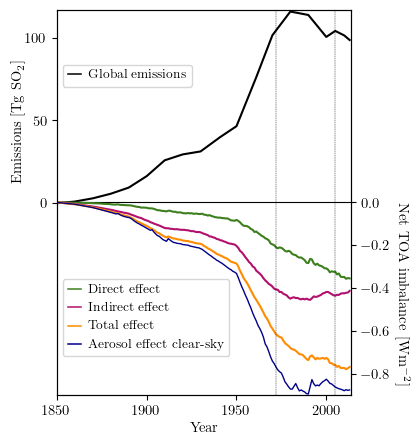

In [ ]:
def plot():
    fig, ax1 = plt.subplots(figsize=(6,6))
    ax2 = ax1.twinx()

    
    historical_dir='/home/anthe/documents/misu/thesis/aerosol-prp/datasets/historical/'
    bot = xr.open_dataset(f'{historical_dir}/historical-CR_all-stream_BOT_fldmean_yearmean.nc').squeeze()
    historical_dir='/home/anthe/documents/misu/paper_aerosols/historical/datasets/'
    prp = xr.open_dataset(f'{historical_dir}/historical_PRP_dR_fldmean_yearmean.nc').squeeze()

    time = np.arange(1850, 1850 + prp.time.size, 1)

    plt.axhline(0, color='black', linewidth=0.8)

    ax2.plot(time, (prp.dR_spd_srad0.values + prp.dR_spd_trad0.values), color=colors['direct'], linestyle='-', label='direct effect')
    ax2.plot(time, (prp.dR_spi_srad0.values + prp.dR_spi_trad0.values), color=colors['indirect'], linestyle='-', label='indirect effect')
    ax2.plot(time, (prp.dR_sp_srad0.values + prp.dR_sp_trad0), 'darkorange', linestyle='-', label='total effect')
    #ax2.legend(loc=(0.01,0.25))
    
    #ax2.plot(time, (prp.dR_spd_srad0.values + prp.dR_spd_trad0.values)/sum*100, color=colors['direct'], linestyle=':', linewidth=1, label='normalized by emissions')
    #ax2.plot(time, (prp.dR_spi_srad0.values + prp.dR_spi_trad0.values)/sum*100, color=colors['indirect'], linestyle=':', linewidth=1,label='indirect effect')
    #ax2.plot(time, (prp.dR_sp_srad0.values + prp.dR_sp_trad0)/sum*100, 'darkorange', linestyle=':', linewidth=1,label='total effect')
    
    #ax2.plot(time, (prp.dR_spd_sraf0.values + prp.dR_spd_traf0.values), color=colors['direct'], linestyle=':', linewidth=1, label='direct clear-sy')
    #ax2.plot(time, (prp.dR_spi_sraf0.values + prp.dR_spi_traf0.values), color=colors['indirect'], linestyle=':', linewidth=1,label='indirect clear-sky')
    ax2.plot(time, (prp.dR_sp_sraf0.values + prp.dR_sp_traf0), 'darkblue', linestyle='-', linewidth=1,label='aerosol effect clear-sky')
    
    #plt.plot(time, 
    ##         (prp.dR_spd_srad0.values + prp.dR_spd_trad0.values) -
    #          (prp.dR_spi_srad0.values+ prp.dR_spi_trad0.values)
    #          , 'darkred', linewidth=1, linestyle='-', label='indirect effect decoupling')
    
    ax1.plot(time, sum, 'black', label='Global emissions')

    ax2.set_ylim([-.9, .9])    
    ax1.set_ylim([-max(sum), max(sum)+1])   

    ax1.yaxis.get_major_ticks()[1].set_visible(False)
    ax1.yaxis.get_major_ticks()[2].set_visible(False)

    ax2.yaxis.get_major_ticks()[6].set_visible(False)
    ax2.yaxis.get_major_ticks()[7].set_visible(False)
    ax2.yaxis.get_major_ticks()[8].set_visible(False)
    ax2.yaxis.get_major_ticks()[9].set_visible(False)

    fs=10.5
    #plt.plot(time_prp, prp.dR_aer_srad0.values, 'darkblue', linestyle='--')
    ax1.set_xlabel('Year', fontsize=fs)
    ax1.set_ylabel(r'Emissions [Tg SO$_2$]', fontsize=fs, labelpad=30)
    ax1.yaxis.set_label_coords(-.11,0.71)
    ax2.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax2.yaxis.set_label_coords(1.2,0.26)

    ax1.set_xlim([1850, 2014])
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    ax2.tick_params(axis='both', which='major', labelsize=fs)
    plt.xticks(np.arange(1850, 2001, 50))
    #plt.ylim([-0.2, None])
    #ax1.legend(loc=(0.01, 0.8))
    fig = plt.gcf()
    fig.set_size_inches(3.8, 5)

    legend_elements = [
    Line2D([0],[2],color="black",markerfacecolor="black",markersize=10,linewidth=1.1)
    ]
    labels = ["Global emissions"]
    ax1.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.8))

    legend_elements = [
    Line2D([0],[2],color=colors['direct'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color=colors['indirect'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkorange",markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkblue",markerfacecolor="black",markersize=10,linewidth=1.1),
    ]
    labels = ["Direct effect", "Indirect effect", "Total effect", "Aerosol effect clear-sky"
]
    leg = ax2.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.1))

    plt.axvline(x=1972, color='black', linewidth=0.3, linestyle='--')
    plt.axvline(x=2005, color='black', linewidth=0.3, linestyle='--')

    leg.set_zorder(1)
    #plt.tight_layout()
    #plt.savefig(f'{fig_dir}prp-timeseries.pdf',bbox_inches='tight')
    
plot()

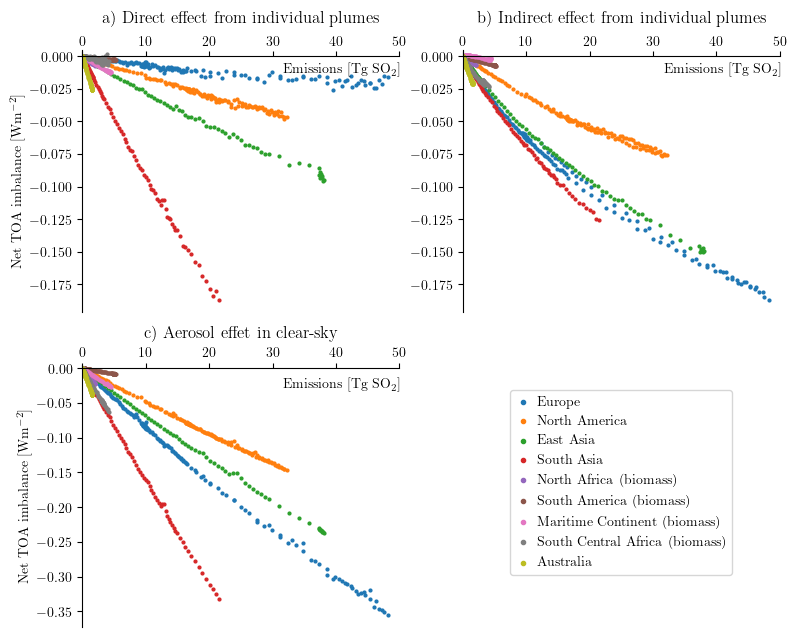

In [ ]:
def plot_figure():

    fig = plt.figure()
    gs = GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    #fig.delaxes(gs[1, 1])

    subplots = {'direct': ax1,
                 'indirect': ax2,
                 'clear-sky':ax3}

    effects = ['direct', 'indirect','clear-sky']

    for ax in [ax1, ax2, ax3]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

    historical_dir='/home/anthe/documents/misu/thesis/aerosol-prp/datasets/historical/'
    bot = xr.open_dataset(f'{historical_dir}/historical-CR_single-plumes_BOT_fldmean_yearmean.nc').squeeze()
    prp = xr.open_dataset(f'{historical_dir}/historical-CR_single-plumes_PRP_fldmean_yearmean.nc').squeeze()
    historical_dir='/home/anthe/documents/misu/paper_aerosols/historical/datasets/'
    clearSky = xr.open_dataset(f'{historical_dir}/historical_PRP_dR_fldmean_yearmean.nc').squeeze()
    
    piControl = xr.open_dataset(f'{piControl_dir}/piControl-CR_fldmean_yearmean.nc').squeeze()
    time = np.arange(1850, 1850 + prp.time.size, 1)

    ms=4
    macsp = xr.open_dataset(f'{MACSP_dir}/MAC-SP.nc')
    for effect in effects:
        for plume_number in range(1, 10, 1):
            label=macsp.attrs[f'plume{plume_number}_region']
            if effect == 'total':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], prp[f'dR_sp{plume_number}_srad0'] + prp[f'dR_sp{plume_number}_trad0'], label=label, s=ms)
            elif effect == 'direct':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], prp[f'dR_spd{plume_number}_srad0'] + prp[f'dR_spd{plume_number}_trad0'], label=label, s=ms)
            elif effect == 'indirect':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], prp[f'dR_spi{plume_number}_srad0'] + prp[f'dR_spi{plume_number}_trad0'], label=label, s=ms)
            elif effect == 'clear-sky':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], clearSky[f'dR_spd{plume_number}_sraf0'] + clearSky[f'dR_spd{plume_number}_traf0'], label=label, s=ms)
    
    #for effect in effects:
    #    if effect == 'direct':
    #         ax1.scatter(sum, prp[f'dR_spd_srad0'] + prp[f'dR_spd_trad0'], label='Direct effect', color=colors['direct'], s=ms)
    #    elif effect == 'indirect':
    #        ax1.scatter(sum, prp[f'dR_spi_srad0'] + prp[f'dR_spi_trad0'], label='Indirect effect', color=colors['indirect'], s=ms)
    #    elif effect == 'total':
    #        ax1.scatter(sum, prp[f'dR_sp_srad0'] + prp[f'dR_sp_trad0'], label='Total effect', color='darkorange', s=ms)    

    ax1.set_title('a) Direct effect from individual plumes', pad=20)
    ax1.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax1.xaxis.set_label_coords(.82, .95)
    ax1.set_xlim([0, 50])
    ax1.set_ylim([None, 0.005])
    ax1.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax1.tick_params(axis='x', direction='in', which='major', pad=-15)
    
    #ax2.tick_params(labelleft = False, labelright=False)
    ax2.set_title('b) Indirect effect from individual plumes', pad=20)
    #ax2.set_xlim([1850, 2014])
    #ax2.set_ylim([-0.2, 0.01])
    ax2.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax2.xaxis.set_label_coords(.82, .95)
    ax2.set_xlim([0, 50])
    ax2.set_ylim([None, 0.005])
    #ax2.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax2.yaxis.set_label_coords(1, -.08)
    #ax2.yaxis.tick_right()
    ax2.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax3.set_title('c) Aerosol effet in clear-sky', pad=20)
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.xaxis.set_label_coords(.82, .95)
    ax3.set_xlim([0, 50])
    ax3.set_ylim([None, 0.005])
    ax3.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)

   
    leg = ax2.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(.15,-1), markerscale=1.5)
    leg.set_zorder(1)
    
    fig = plt.gcf()
    fig.set_size_inches(9, 7.5)
    #fig.subplots_adjust(wspace=1)
    #plt.title('Gregory-regression difference between 2005 and 1970 \nin abrupt-aerosol experiments')
    #plt.tight_layout()
    plt.savefig(f'../figures/forcing-vs-emissions-individual-plumes.pdf')

plot_figure()

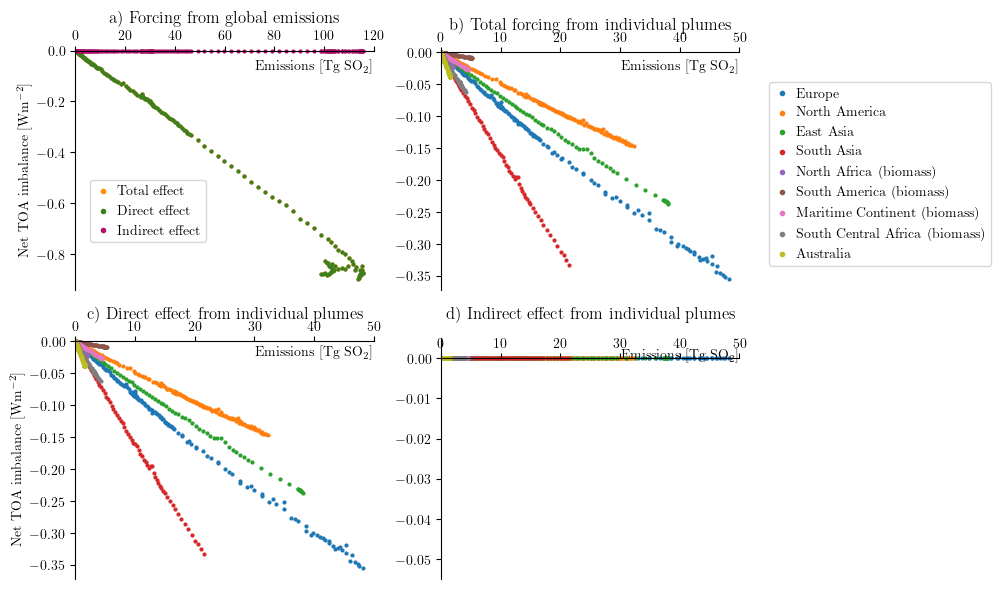

In [ ]:
def plot_figure():

    fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)

    subplots = {'total': ax2,
                'direct': ax3,
                 'indirect': ax4}

    effects = ['total', 'direct', 'indirect']

    #ax3.spines['left'].set_position('zero')
    ax3.spines['bottom'].set_position('zero')
    ax3.spines['right'].set_color('none')
    ax3.spines['top'].set_color('none')

    #ax2.spines['left'].set_position('zero')
    ax2.spines['bottom'].set_position('zero')
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')

    #ax1.spines['left'].set_position('zero')
    ax1.spines['bottom'].set_position('zero')
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    
    ax4.spines['bottom'].set_position('zero')
    ax4.spines['right'].set_color('none')
    ax4.spines['top'].set_color('none')
    #historical_dir='/home/anthe/documents/misu/thesis/aerosol-prp/datasets/historical/'
    #bot = xr.open_dataset(f'{historical_dir}/historical-CR_single-plumes_BOT_fldmean_yearmean.nc').squeeze()
    historical_dir='/home/anthe/documents/misu/paper_aerosols/historical/datasets/'
    prp = xr.open_dataset(f'{historical_dir}/historical_PRP_dR_fldmean_yearmean.nc').squeeze()
   # piControl = xr.open_dataset(f'{piControl_dir}/piControl-CR_fldmean_yearmean.nc').squeeze()
   # time = np.arange(1850, 1850 + prp.time.size, 1)

    ms=4
    macsp = xr.open_dataset(f'{MACSP_dir}/MAC-SP.nc')
    for effect in effects:
        for plume_number in range(1, 10, 1):
            label=macsp.attrs[f'plume{plume_number}_region']
            if effect == 'total':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], prp[f'dR_sp{plume_number}_sraf0'] + prp[f'dR_sp{plume_number}_traf0'], label=label, s=ms)
            elif effect == 'direct':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], prp[f'dR_spd{plume_number}_sraf0'] + prp[f'dR_spd{plume_number}_traf0'], label=label, s=ms)
            #elif effect == 'indirect':
            #    subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], #prp[f'dR_spi{plume_number}_sraf0'] + prp[f'dR_spi{plume_number}_traf0'], label=label, s=ms)
            elif effect == 'indirect':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], prp[f'dR_sp{plume_number}_sraf0'] - prp[f'dR_sp{plume_number}_sraf0'], label=label, s=ms)
    
    for effect in effects:
        if effect == 'direct':
             ax1.scatter(sum, prp[f'dR_spd_sraf0'] + prp[f'dR_spd_traf0'], label='Direct effect', color=colors['direct'], s=ms)
        elif effect == 'indirect':
            ax1.scatter(sum, prp[f'dR_spi_sraf0'] + prp[f'dR_spi_traf0'], label='Indirect effect', color=colors['indirect'], s=ms)
        elif effect == 'total':
            ax1.scatter(sum, prp[f'dR_sp_sraf0'] + prp[f'dR_sp_traf0'], label='Total effect', color='darkorange', s=ms)    

    ax3.set_title('c) Direct effect from individual plumes', pad=15)
    #ax1.set_xlim([1850, 2014])
    #ax1.set_ylim([-0.2, 0.01])
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.xaxis.set_label_coords(.8, .97)
    ax3.set_xlim([0, 50])
    ax3.set_ylim([None, 0.005])
    ax3.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax1.yaxis.set_label_coords(1, -.08)
    #ax1.yaxis.tick_right()
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)
    
    #ax2.tick_params(labelleft = False, labelright=False)
    ax4.set_title('d) Indirect effect from individual plumes', pad=15)
    #ax2.set_xlim([1850, 2014])
    #ax2.set_ylim([-0.2, 0.01])
    ax4.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax4.xaxis.set_label_coords(.8, .96)
    ax4.set_xlim([0, 50])
    ax4.set_ylim([None, 0.005])
    #ax2.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax2.yaxis.set_label_coords(1, -.08)
    #ax2.yaxis.tick_right()
    ax4.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax2.set_title('b) Total forcing from individual plumes', pad=15)
    #ax3.set_xlim([1850, 2014])
    ax1.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")
    ax2.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax2.xaxis.set_label_coords(.8, .96)
    ax2.set_xlim([0, 50])
    ax2.set_ylim([None, 0.005])
    #ax3.yaxis.set_label_coords(1, -.08)
    #ax3.yaxis.tick_right()
    ax2.tick_params(axis='x', direction='in', which='major', pad=-15)
   
    leg = ax2.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(1.1,0.1), markerscale=1.5)
    leg.set_zorder(1)

    ax1.set_title('a) Forcing from global emissions', pad=20)
    #ax4.set_xlim([1850, 2014])
    #ax4.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")
    ax1.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax1.set_xlim([0, 120])
    ax1.set_ylim([None, 0.005])
    ax1.xaxis.set_label_coords(.8, .96)
    #ax3.yaxis.set_label_coords(1, -.08)
    #ax3.yaxis.tick_right()
    ax1.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax1.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(0.05,.2), markerscale=1.5)
    
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    fig.subplots_adjust(wspace=1)
    #plt.title('Gregory-regression difference between 2005 and 1970 \nin abrupt-aerosol experiments')
    plt.tight_layout()
    #plt.savefig(f'{fig_dir}/PRP-vs-emissions-individual-plumes.pdf')

plot_figure()

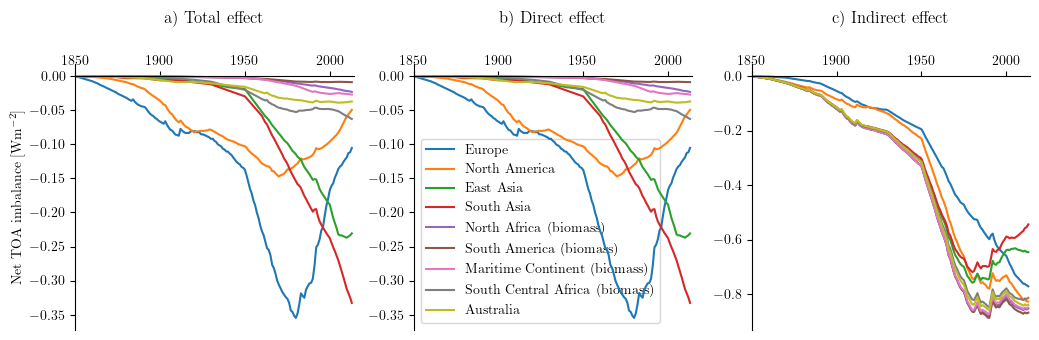

In [ ]:
def plot_figure():

    exp={'bg1', 'bg05'}
    colors={'bg1':"darkorange",
            'bg05':"darkmagenta"}
    effects = {'total', 'direct', 'indirect'}
    #ax1 = plt.subplot(221)
    #ax2 = plt.subplot(222)
    #ax3 = plt.subplot(212)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3)

    subplots = {'total': ax1,
                'direct': ax2,
                 'indirect': ax3}
    colors = {'p1': 'darkgreen',
                'p3': 'darkmagenta',
                 'cp': 'darkorange'}
    effects = ['total', 'direct', 'indirect']

    #ax3.spines['left'].set_position('zero')
    ax3.spines['bottom'].set_position('zero')
    ax3.spines['right'].set_color('none')
    ax3.spines['top'].set_color('none')

    #ax2.spines['left'].set_position('zero')
    ax2.spines['bottom'].set_position('zero')
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')

    #ax1.spines['left'].set_position('zero')
    ax1.spines['bottom'].set_position('zero')
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    
    #ax4.spines['bottom'].set_position('zero')
    #ax4.spines['right'].set_color('none')
    #ax4.spines['top'].set_color('none')
    historical_dir='/home/anthe/documents/misu/paper_aerosols/historical/datasets/'
    prp = xr.open_dataset(f'{historical_dir}/historical_PRP_dR_fldmean_yearmean.nc').squeeze()
    time = np.arange(1850, 1850 + prp.time.size, 1)

    for effect in effects:
        for plume_number in range(1, 10, 1):
            label=macsp.attrs[f'plume{plume_number}_region']
            if effect == 'total':
                subplots[effect].plot(time, prp[f'dR_sp{plume_number}_sraf0'] + prp[f'dR_sp{plume_number}_traf0'], label=label)
            elif effect == 'direct':
                subplots[effect].plot(time, prp[f'dR_spd{plume_number}_sraf0'] + prp[f'dR_spd{plume_number}_traf0'], label=label)
            elif effect == 'indirect':
                subplots[effect].plot(time, prp[f'dR_spi{plume_number}_sraf0'] + prp[f'dR_spi{plume_number}_traf0'], label=label)
    
    #for effect in effects:
    #    if effect == 'direct':
    #         ax4.plot(time, prp[f'dR_spd_srad0'] + prp[f'dR_spd_trad0'], label='Direct effect', color='darkgreen')
    #    elif effect == 'indirect':
    #        ax4.plot(time, prp[f'dR_spi_srad0'] + prp[f'dR_spi_trad0'], label='Indirect effect', color='darkmagenta')
    #    elif effect == 'total':
    #        ax4.plot(time, prp[f'dR_sp_srad0'] + prp[f'dR_sp_trad0'], label='Total effect', color='darkorange')    
    plume_number=1
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    #for i in emissions:
    #    #plt.plot(emissions.index, emissions[i], label=macsp.attrs[f'plume{plume_number}_region'])
    #    ax4.plot(macsp.years, macsp.year_weight.sel(plume_number=plume_number)*emissions[i].loc[2005], color=colors[plume_number-1], linestyle='-', label=macsp.attrs[f'plume{plume_number}_region'])
    #    plume_number=plume_number+1

    ax1.set_title('a) Total effect', pad=30)
    ax1.set_xlim([1850, 2014])
    #ax1.set_ylim([-0.32, 0])
    #ax1.set_ylim([-0.2, 0.01])
    #ax1.set_xlabel("Forcing [Wm$^{-2}$]")
    #ax1.xaxis.set_label_coords(.13, .96)
    ax1.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax1.yaxis.set_label_coords(1, -.08)
    #ax1.yaxis.tick_right()
    ax1.tick_params(axis='x', direction='in', which='major', pad=-15)
    
    #ax2.tick_params(labelleft = False, labelright=False)
    ax2.set_title('b) Direct effect', pad=30)
    ax2.set_xlim([1850, 2014])
   # ax2.set_ylim([-0.32, 0])
    #ax2.tick_params(labelleft = False, labelright=False)
    ax2.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax3.set_title('c) Indirect effect', pad=30)
    ax3.set_xlim([1850, 2014])
    #ax3.set_ylim([-0.32, 0])
    #ax3.tick_params(labelleft = False, labelright=False)
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)
   
    ax2.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(0.05,.05))
    
    leg = ax2.legend()
    leg.set_zorder(1)

    fig = plt.gcf()
    fig.set_size_inches(10.5,3.5)
    #plt.title('Gregory-regression difference between 2005 and 1970 \nin abrupt-aerosol experiments')
    plt.tight_layout()
    #plt.savefig(f'{fig_dir}/single-plumes-effects_historical-timeseries.pdf')

plot_figure()